# High-Level Description

This notebook performs the simplest possible test of CorrCal: calibration of an array with noiselike gain calibration errors with a sky consisting of a single point source.

TODO: rewrite the `simple_nll` and `simple_grad_nll` functions to operate purely on the real/imaginary components, rather than do the complex treatment. See if that improves the functionality.

In [1]:
from astropy import units, constants
from scipy.optimize import fmin_cg, minimize

import numpy as np
import corrcal
import hera_sim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["font.size"] = 12
plt.rcParams["figure.facecolor"] = "white"

In [3]:
# Some basic simulation setup.
freq = 150 * units.MHz
wl = constants.c / freq
src_flux = 100  # Jy; Tsky ~ 1.44 K for \Omega_p = 1
antpos = hera_sim.antpos.hex_array(3, split_core=False, outriggers=0)
integration_time = 10.7  # s
channel_width = 100e3  # Hz

In [4]:
hera_sim.defaults.set('h1c')
sim = hera_sim.Simulator(
    polarization_array=np.atleast_1d("xx"),
    start_freq=150e6,
    Nfreqs=1,
    channel_width=channel_width,
    start_time=2458041,
    Ntimes=1,
    integration_time=integration_time,
    array_layout=antpos,
)

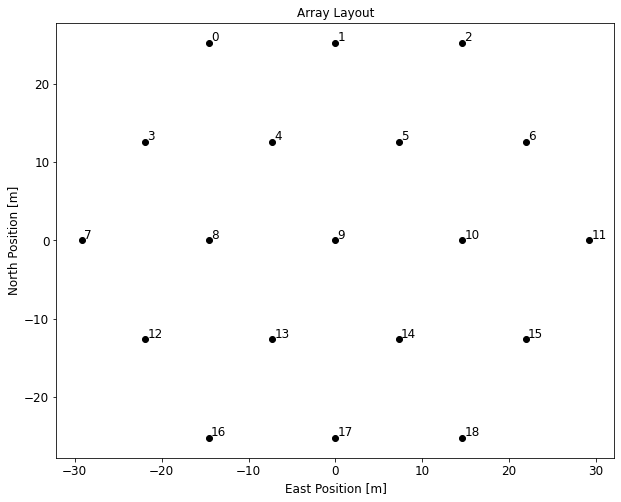

In [5]:
sim.plot_array();

In [6]:
sim.data.select(antenna_nums=np.array([0,1,2,8,9,10,16,17,18]))

In [7]:
sim.data.data_array[...] = src_flux
Trx = 1  # K
sim.add("thermal_noise", Trx=Trx, omega_p=np.atleast_1d(1), channel_width=channel_width, integration_time=integration_time)
sim.data.select(ant_str="cross")

You have not specified how to seed the random state. This effect might not be exactly recoverable.


In [8]:
# Construct baseline array.
bls = []
for ai, aj in zip(sim.data.ant_1_array, sim.data.ant_2_array):
    bls.append(antpos[aj] - antpos[ai])
bls = np.array(bls)

# Get a mapping of antenna numbers -> indices.
antnums = sim.data.antenna_numbers
ant_1_inds = np.zeros_like(sim.data.ant_1_array)
ant_2_inds = np.zeros_like(sim.data.ant_2_array)
for i, ant in enumerate(antnums):
    ant_1_inds[sim.data.ant_1_array == ant] = i
    ant_2_inds[sim.data.ant_2_array == ant] = i
    
# Extract the data.
data = sim.data.data_array[:,0,0,0]

# Convert baseline lengths to uvws, then sort everything into redundant groups.
uvws = bls / wl.to('m').value
sort, edges, conj = corrcal.gridding.make_redundant_groups(*uvws.T[:2])
uvws = uvws[sort,:]
uvws[conj,:] *= -1
data = data[sort]
data[conj] = data[conj].conj()
ant_1_inds = ant_1_inds[sort]
ant_2_inds = ant_2_inds[sort]
tmp_inds = ant_1_inds.copy()
ant_1_inds[conj] = ant_2_inds[conj]
ant_2_inds[conj] = tmp_inds[conj]

In [9]:
# Make the covariance matrices.
src_mat = np.ones((data.size, 1), dtype=complex) * src_flux
diff_mat = np.zeros((data.size, edges.size - 1), dtype=complex)
for i, (start, stop) in enumerate(zip(edges, edges[1:])):
    diff_mat[start:stop,i] = src_flux
    
src_cov = src_mat @ src_mat.T.conj()
diff_cov = diff_mat @ diff_mat.T.conj()
full_cov = src_cov + diff_cov

noise_level = (
    src_flux + Trx/hera_sim.utils.jansky_to_kelvin(freq.to("GHz").value, 1)
) / np.sqrt(integration_time * channel_width)
noise = np.ones(src_cov.shape[0], dtype=complex) * noise_level**2

In [10]:
# Generate noiselike gain errors
error_level = 0.05
gains = np.random.normal(
    loc=1, scale=error_level, size=antnums.size
) + 1j*np.random.normal(
    loc=0, scale=error_level, size=antnums.size
)
init_gains = np.zeros(2*antnums.size, dtype=float)
init_gains[:antnums.size] = gains.real
init_gains[antnums.size:] = gains.imag

In [11]:
gain_scale = 1e4
scale = 1
args = (data, noise, src_cov, ant_1_inds, ant_2_inds, "simple", gain_scale, scale)
sol, hist = fmin_cg(
    corrcal.optimize.simple_nll,
    init_gains * gain_scale,
#     method="CG",
    fprime=corrcal.optimize.simple_grad_nll,
    args=args,
    maxiter=10,
    retall=True,
)

         Current function value: 1255.371877
         Iterations: 0
         Function evaluations: 54
         Gradient evaluations: 42


Gradient may not be well-behaved.


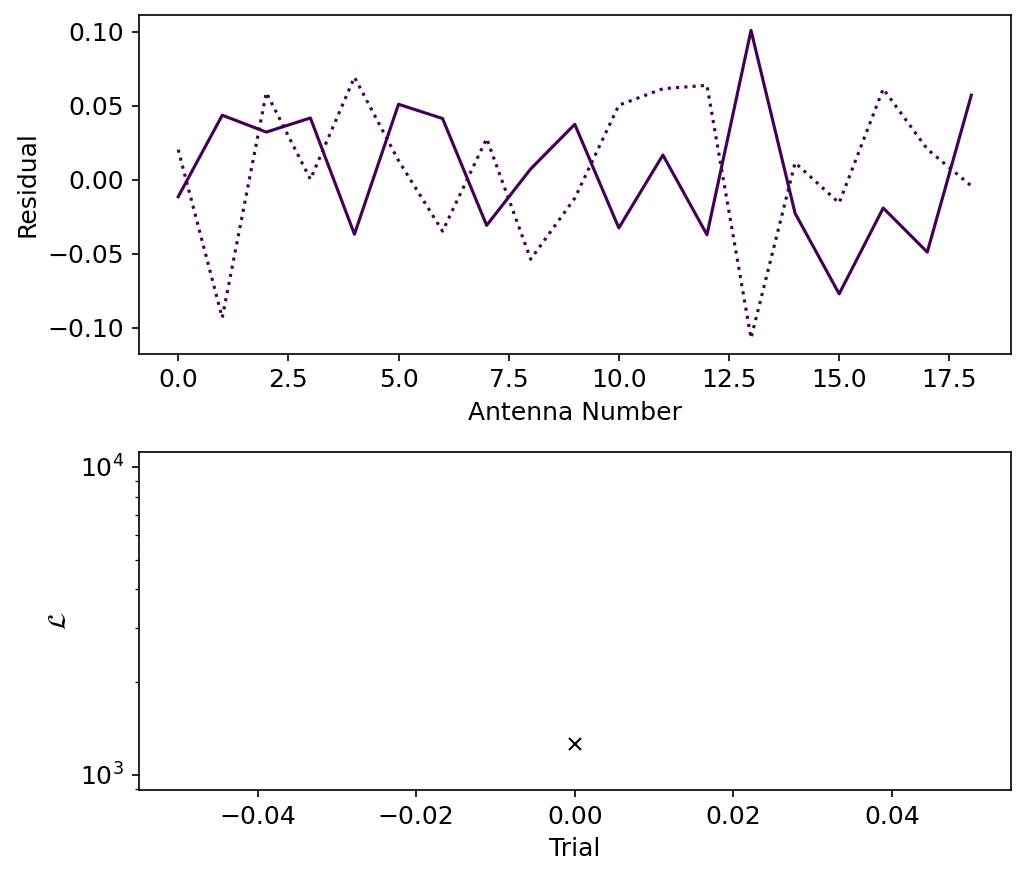

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(7,6), dpi=150, facecolor='w')
axes[0].set_xlabel("Antenna Number")
axes[0].set_ylabel("Residual")
axes[1].set_xlabel("Trial")
axes[1].set_ylabel(r"${\cal L}$")
n_ants = sim.Nants
re = slice(None,n_ants)
im = slice(n_ants,None)
cmap = plt.cm.viridis
norm = plt.cm.colors.Normalize(0, len(hist)-1)
for trial, gain in enumerate(hist):
    c = cmap(norm(trial))
    axes[0].plot(gain[re]/gain_scale - 1, label=f"Trial {trial}, Real", color=c)
    axes[0].plot(gain[im]/gain_scale, label=f"Trial {trial}, Imag", color=c, ls=':')
    axes[1].semilogy(trial, corrcal.optimize.simple_nll(gain, *args), 'kx')
# axes[0].legend(ncol=trial+1)
fig.tight_layout()

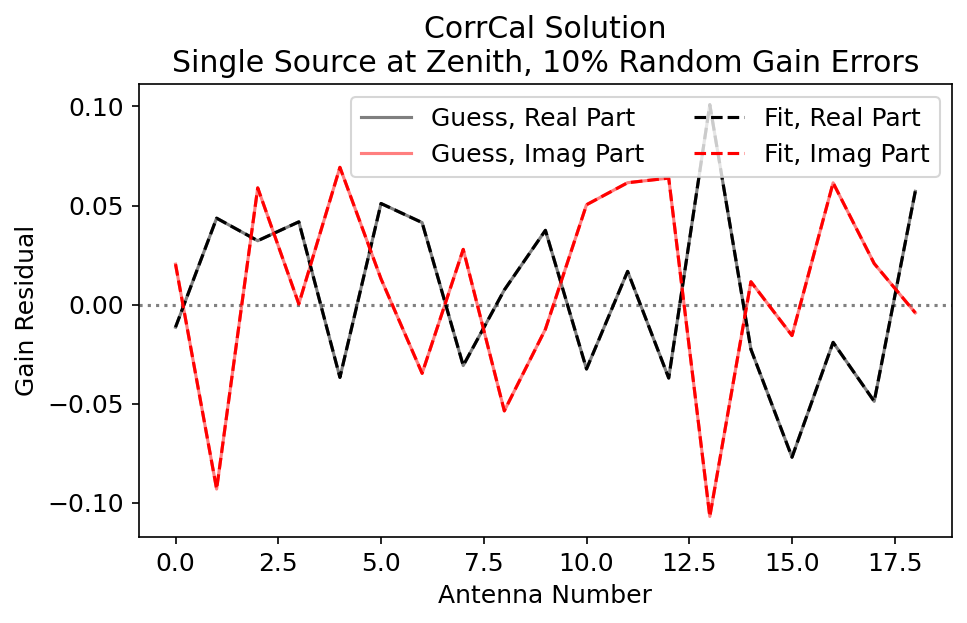

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7,4), dpi=150)
fit_gains = sol / gain_scale
ax.set_xlabel("Antenna Number")
ax.set_ylabel("Gain Residual")
ax.set_title("CorrCal Solution\nSingle Source at Zenith, 10% Random Gain Errors")
# ax.axhline(1, color="k", ls=":", label="Truth")
ax.axhline(0, color="grey", ls=":")#, label="Truth")
ax.plot(antnums, init_gains[:antnums.size] - 1, color="k", label="Guess, Real Part", alpha=0.5)
ax.plot(antnums, init_gains[antnums.size:], color="r", label="Guess, Imag Part", alpha=0.5)
ax.plot(antnums, fit_gains[:antnums.size] - 1, color="k", ls='--', label="Fit, Real Part")
ax.plot(antnums, fit_gains[antnums.size:], color="r", ls='--', label="Fit, Imag Part")
ax.legend(ncol=2)

Gradient may not be well-behaved.


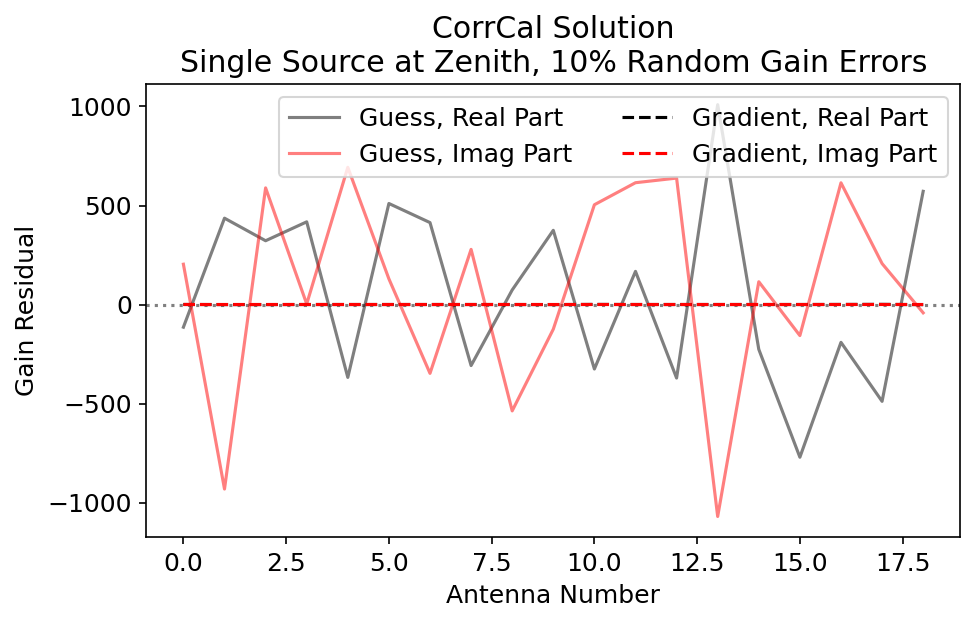

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7,4), dpi=150)
gradient = corrcal.optimize.simple_grad_nll(init_gains * gain_scale, *args)
ax.set_xlabel("Antenna Number")
ax.set_ylabel("Gain Residual")
ax.set_title("CorrCal Solution\nSingle Source at Zenith, 10% Random Gain Errors")
# ax.axhline(1, color="k", ls=":", label="Truth")
ax.axhline(0, color="grey", ls=":")#, label="Truth")
ax.plot(antnums, gain_scale*(init_gains[:antnums.size] - 1), color="k", label="Guess, Real Part", alpha=0.5)
ax.plot(antnums, gain_scale*init_gains[antnums.size:], color="r", label="Guess, Imag Part", alpha=0.5)
ax.plot(antnums, gradient[:antnums.size], color="k", ls='--', label="Gradient, Real Part")
ax.plot(antnums, gradient[antnums.size:], color="r", ls='--', label="Gradient, Imag Part")
ax.legend(ncol=2)